In [0]:
!pip install -q pandas-datareader

In [0]:
!pip install -q ta

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import ta
import time
import math

import numpy as np

import pandas as pd
import pandas_datareader as web

import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
mpl.style.use('seaborn')

In [0]:
stock_symbol = 'NTAP'
screen_width = 17
previous_days = 120

In [0]:
# Current Timestamp
ts = int(time.time())
# Current date from ts
the_date = datetime.fromtimestamp(ts)
# New date as string
new_date = the_date.strftime("%Y-%m-%d")

In [908]:
df = web.DataReader(stock_symbol, data_source='yahoo', start='1900-01-01', end=new_date)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1995-11-21,1.328125,1.078125,1.078125,1.281250,51412800.0,1.108930
1995-11-22,1.609375,1.265625,1.281250,1.562500,11921600.0,1.352354
1995-11-24,1.703125,1.562500,1.562500,1.687500,2419200.0,1.460542
1995-11-27,1.812500,1.531250,1.781250,1.578125,6720000.0,1.365877
1995-11-28,1.609375,1.562500,1.578125,1.593750,3451200.0,1.379401


In [0]:
train_length = math.ceil(len(df) * .8)
# train_length = len(df)-600

In [912]:
df = ta.utils.dropna(df)

df = ta.add_all_ta_features(df, open='Open', high='High', low='Low', close='Adj Close', volume='Volume', fillna=True)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


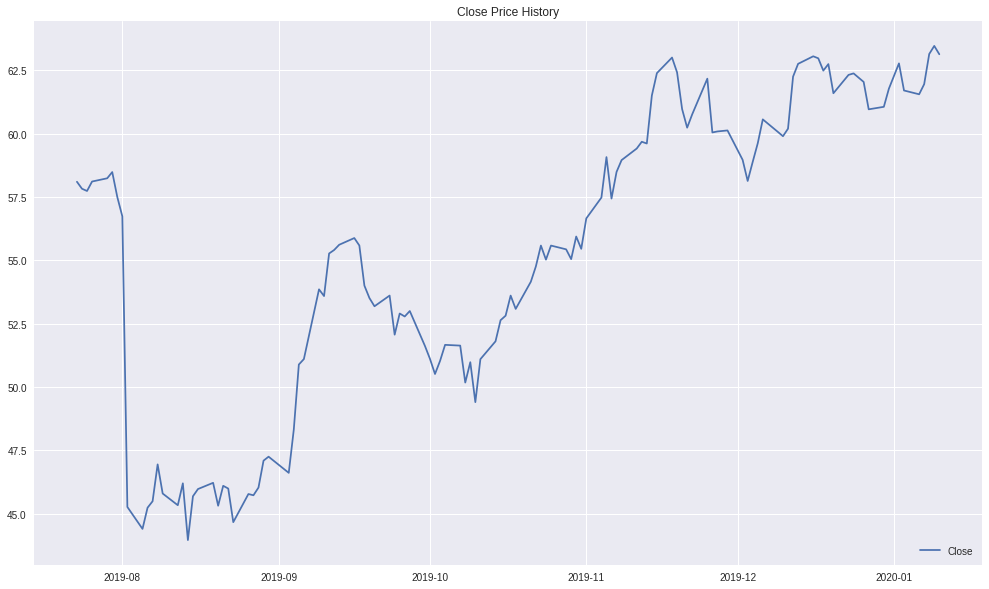

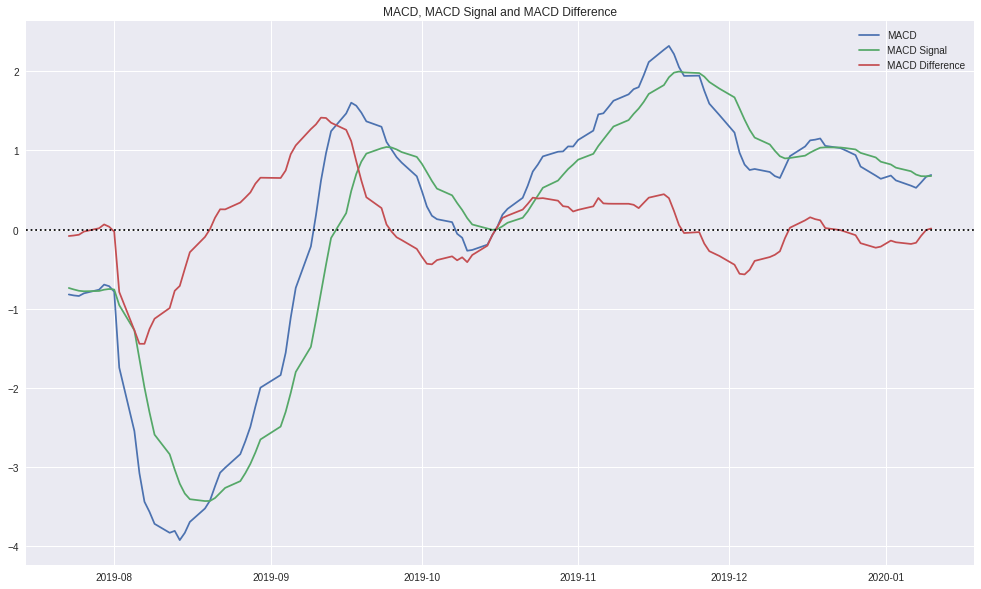

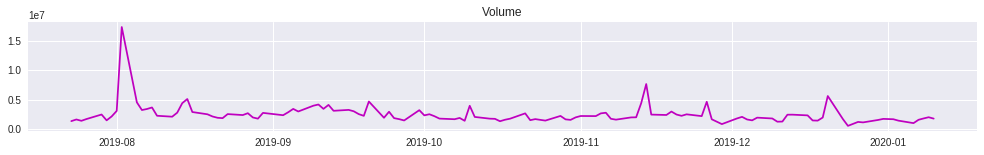

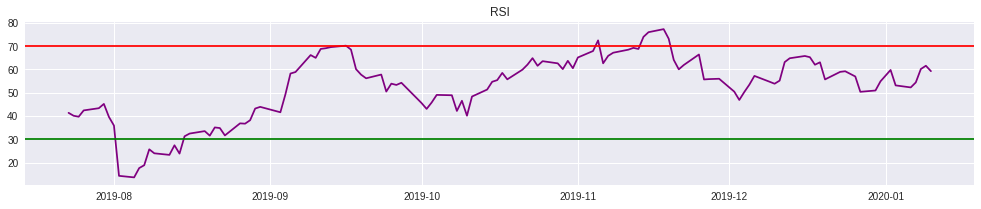

In [913]:
close = df['Adj Close']
high = df['High']
low = df['Low']
open_df = df['Open']
volume = df['Volume']
rsi = df.momentum_rsi
macd = df.trend_macd
macd_signal = df.trend_macd_signal
macd_diff = df.trend_macd_diff

last_days = len(df)-previous_days

# Prices Close, Lows, Highs
plt.figure(figsize=(screen_width,10))
plt.title('Close Price History')
plt.plot(close[last_days:], label='Close')
# plt.plot(high[last_days:], label='High')
# plt.plot(low[last_days:], label='Low')
# plt.plot(open_df[last_days:], label='Open')
plt.legend(['Close', 'Open'], loc='lower right')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# MACD Chart
plt.figure(figsize=(screen_width,10))
plt.plot(df[last_days:].trend_macd, label='MACD')
plt.plot(df[last_days:].trend_macd_signal, label='MACD Signal')
plt.plot(df[last_days:].trend_macd_diff, label='MACD Difference')
plt.axhline(y=0, linestyle=':',color='black')
plt.title('MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

# Volume Chart
plt.figure(figsize=(screen_width,2))
plt.title('Volume')
plt.plot(volume[last_days:], color='m')
plt.show()

# RSI Chart
plt.figure(figsize=(screen_width,3))
plt.title('RSI')
plt.plot(df[last_days:].momentum_rsi, label='RSI', color='purple')
plt.axhline(y=70, color='red')
plt.axhline(y=30, color='green')
plt.show()

In [0]:
dataset = []

for i in range(0, len(macd)):
  if macd_diff[i] < 0 and rsi[i] < 30:
    dataset.append([macd.index[i], macd[i], macd_signal[i], macd_diff[i], round(open_df[i],2), round(close[i],2), 'BUY'])
  elif macd_diff[i] > 0 and rsi[i] > 70:
    dataset.append([macd.index[i], macd[i], macd_signal[i], macd_diff[i], round(open_df[i],2), round(close[i],2), 'SELL'])
  else:
    dataset.append([macd.index[i], macd[i], macd_signal[i], macd_diff[i], round(open_df[i],2), round(close[i],2), '<WAIT>'])

# dataset

In [0]:
df_both = pd.DataFrame(dataset, columns=['date', 'macd', 'macd_signal', 'macd_diff', 'open', 'close','signal'])
# df_both

In [0]:
# df_both.head(20)

In [917]:
pred_buys = []
pred_sells = []

for i in range(train_length, len(df_both)):

  # if signal is equal to buy
  if df_both['signal'][i] == 'BUY':

    # if current_close less than previous_close and
    if df_both['open'][i] < df_both['open'][i-1] and df_both['signal'][i-1] == 'BUY':
      if rsi[i] < rsi[i-1]:
        print(df_both.index[i], ' ',df_both['date'][i], ' ' ,df_both['signal'][i], ' ',df_both['open'][i], ' ',df_both['close'][i], 'BUY THIS AFTERNOON BEFORE CLOSE', round(rsi[i], 1))
        pred_buys.append([df_both['date'][i], df_both['signal'][i], df_both['open'][i], df_both['close'][i], 'BUY THIS AFTERNOON BEFORE CLOSE'])
    elif df_both['signal'][i-1] == 'BUY':
      print(df_both.index[i], ' ',df_both['date'][i], ' ' ,df_both['signal'][i], ' ',df_both['open'][i], ' ',df_both['close'][i], round(rsi[i], 1), round(rsi[i], 1))
      # pred.append([df_both['date'][i], df_both['signal'][i], df_both['open'][i], df_both['close'][i], rsi[i]])
  
  # if signal is equal to sell
  if df_both['signal'][i] == 'SELL':

    # if current_close greater than previous_close and signal not equal to sell
    if df_both['close'][i] > df_both['close'][i-1] and df_both['signal'][i-1] != 'SELL':
      print(df_both.index[i], ' ',df_both['date'][i], ' ' ,df_both['signal'][i], ' ',df_both['open'][i], ' ',df_both['close'][i], 'SELL NEXT DAY AT OPEN', round(rsi[i], 1))
      pred_buys.append([df_both['date'][i], df_both['signal'][i], df_both['open'][i], df_both['close'][i], 'SELL NEXT DAY AT OPEN'])
    else:
      print(df_both.index[i], ' ',df_both['date'][i], ' ' ,df_both['signal'][i], ' ',df_both['open'][i], ' ',df_both['close'][i], round(rsi[i], 1))
      # pred.append([df_both['date'][i], df_both['signal'][i], df_both['open'][i], df_both['close'][i], rsi[i]])

  if df_both['signal'][i] == '<WAIT>':
    print(df_both.index[i], ' ',df_both['date'][i], ' ' ,df_both['signal'][i], ' ',df_both['open'][i], ' ',df_both['close'][i], round(rsi[i], 1))
    # pred.append([df_both['date'][i], df_both['signal'][i], df_both['open'][i], df_both['close'][i], rsi[i]])

4861   2015-03-18 00:00:00   <WAIT>   36.78   33.21 42.6
4862   2015-03-19 00:00:00   <WAIT>   37.28   32.67 38.1
4863   2015-03-20 00:00:00   <WAIT>   36.9   33.23 44.6
4864   2015-03-23 00:00:00   <WAIT>   36.52   32.62 39.7
4865   2015-03-24 00:00:00   <WAIT>   36.74   31.92 34.9
4866   2015-03-25 00:00:00   <WAIT>   35.79   31.82 34.2
4867   2015-03-26 00:00:00   <WAIT>   35.43   31.65 33.1
4868   2015-03-27 00:00:00   <WAIT>   35.64   31.25 30.6
4869   2015-03-30 00:00:00   <WAIT>   35.22   31.5 34.0
4870   2015-03-31 00:00:00   <WAIT>   35.34   31.57 34.9
4871   2015-04-01 00:00:00   <WAIT>   35.4   31.4 33.7
4872   2015-04-02 00:00:00   <WAIT>   35.32   31.72 38.2
4873   2015-04-06 00:00:00   <WAIT>   35.36   32.08 42.9
4874   2015-04-07 00:00:00   <WAIT>   36.07   31.88 41.1
4875   2015-04-08 00:00:00   <WAIT>   35.75   32.04 43.2
4876   2015-04-09 00:00:00   <WAIT>   35.69   31.97 42.5
4877   2015-04-10 00:00:00   <WAIT>   35.71   31.73 39.9
4878   2015-04-13 00:00:00   <WAIT>

In [918]:
pred_buys = pd.DataFrame(pred_buys, columns=['date', 'signal', 'open', 'close', 'rsi'])
pred_buys

,date,signal,open,close,rsi
0,2015-07-09,BUY,30.73,27.30,BUY THIS AFTERNOON BEFORE CLOSE
1,2015-10-14,SELL,33.46,30.65,SELL NEXT DAY AT OPEN
2,2015-10-16,SELL,33.79,30.60,SELL NEXT DAY AT OPEN
3,2015-10-22,SELL,33.56,31.11,SELL NEXT DAY AT OPEN
4,2015-12-14,BUY,29.37,25.94,BUY THIS AFTERNOON BEFORE CLOSE
5,2015-12-15,BUY,28.92,25.85,BUY THIS AFTERNOON BEFORE CLOSE
6,2015-12-18,BUY,28.09,24.97,BUY THIS AFTERNOON BEFORE CLOSE
7,2015-12-22,BUY,25.66,23.73,BUY THIS AFTERNOON BEFORE CLOSE
8,2016-01-04,BUY,26.16,23.54,BUY THIS AFTERNOON BEFORE CLOSE
9,2016-01-05,BUY,26.09,22.98,BUY THIS AFTERNOON BEFORE CLOSE


In [919]:
pred_sells = pd.DataFrame(pred_sells, columns=['date', 'signal', 'open', 'close', 'rsi'])
# pred_sells

,date,signal,open,close,rsi


In [920]:
# fund = 1000
# print('fund: ', fund)
# dca_account = round((fund * 0.8),2)
# print('dca_account: ', dca_account)
# trade_account = round((fund * 0.2),2)
# print('trade_account: ', trade_account)

fund:  1000
dca_account:  800.0
trade_account:  200.0
